<a href="https://colab.research.google.com/github/Qurvie1/calibration_research/blob/master/calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install betacal
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from matplotlib.ticker import PercentFormatter
from torchvision.models import resnet50
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from scipy.optimize import minimize_scalar
from betacal import BetaCalibration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Преобразования для данных
transform = transforms.Compose([
    transforms.Resize(32),  # ResNet-18 ожидает 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Нормализация для MNIST
])

# Загрузка данных
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.29MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.64MB/s]


Теперь загрузим ResNet, LeNet

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*5*5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = resnet50(weights=None) # модель
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # обновим первый слой, так как MNIST одноканальный
model.fc = nn.Linear(in_features=2048, out_features=10) # сразу сделаем многоклассовую

model2 = LeNet5().to(device)
model = model.to(device) # на gpu

Обучим модель, впоследствии код на трейн можно в другой модели использовать будет

In [ ]:
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)


    return running_loss / len(loader), correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total

Обучим LeNet

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

# Цикл обучения
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train(model2, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model2, test_loader, criterion)

    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}\n')

Epoch 1/10:
Train Loss: 0.3597 | Train Acc: 0.8935
Val Loss: 0.1074 | Val Acc: 0.9673

Epoch 2/10:
Train Loss: 0.1005 | Train Acc: 0.9702
Val Loss: 0.0662 | Val Acc: 0.9780

Epoch 3/10:
Train Loss: 0.0725 | Train Acc: 0.9780
Val Loss: 0.0506 | Val Acc: 0.9834

Epoch 4/10:
Train Loss: 0.0575 | Train Acc: 0.9820
Val Loss: 0.0499 | Val Acc: 0.9839

Epoch 5/10:
Train Loss: 0.0471 | Train Acc: 0.9852
Val Loss: 0.0469 | Val Acc: 0.9828

Epoch 6/10:
Train Loss: 0.0397 | Train Acc: 0.9874
Val Loss: 0.0341 | Val Acc: 0.9881

Epoch 7/10:
Train Loss: 0.0363 | Train Acc: 0.9883
Val Loss: 0.0296 | Val Acc: 0.9905

Epoch 8/10:
Train Loss: 0.0293 | Train Acc: 0.9907
Val Loss: 0.0342 | Val Acc: 0.9883

Epoch 9/10:
Train Loss: 0.0275 | Train Acc: 0.9910
Val Loss: 0.0371 | Val Acc: 0.9886

Epoch 10/10:
Train Loss: 0.0238 | Train Acc: 0.9922
Val Loss: 0.0393 | Val Acc: 0.9865



Обучим ResNet

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Цикл обучения
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}\n')

Epoch 1/10:
Train Loss: 0.2495 | Train Acc: 0.9242
Val Loss: 0.0719 | Val Acc: 0.9778

Epoch 2/10:
Train Loss: 0.0641 | Train Acc: 0.9804
Val Loss: 0.0610 | Val Acc: 0.9817

Epoch 3/10:
Train Loss: 0.0426 | Train Acc: 0.9874
Val Loss: 0.0554 | Val Acc: 0.9834

Epoch 4/10:
Train Loss: 0.0367 | Train Acc: 0.9891
Val Loss: 0.0450 | Val Acc: 0.9881

Epoch 5/10:
Train Loss: 0.0357 | Train Acc: 0.9896
Val Loss: 0.0499 | Val Acc: 0.9863

Epoch 6/10:
Train Loss: 0.0310 | Train Acc: 0.9909
Val Loss: 0.0394 | Val Acc: 0.9891

Epoch 7/10:
Train Loss: 0.0285 | Train Acc: 0.9917
Val Loss: 0.0347 | Val Acc: 0.9888

Epoch 8/10:
Train Loss: 0.0245 | Train Acc: 0.9931
Val Loss: 0.0514 | Val Acc: 0.9865

Epoch 9/10:
Train Loss: 0.0285 | Train Acc: 0.9913
Val Loss: 0.0399 | Val Acc: 0.9874

Epoch 10/10:
Train Loss: 0.0231 | Train Acc: 0.9939
Val Loss: 0.0368 | Val Acc: 0.9897



In [ ]:
def get_model_predictions(model, loader):
    model.eval()
    confidences = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            probs = F.softmax(outputs, dim=1).cpu().numpy()

            confidences.append(probs)
            true_labels.append(labels.cpu().numpy())

    confidences = np.vstack(confidences)  # [n_samples, n_classes]
    true_labels = np.concatenate(true_labels)  # [n_samples]

    return confidences, true_labels

In [ ]:
def calculate_ece(confidences, labels, n_bins=10):
    pred_classes = np.argmax(confidences, axis=1)
    confidences = np.max(confidences, axis=1)
    accuracies = (pred_classes == labels)

    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    for bin_low, bin_up in zip(bin_lowers, bin_uppers):
        indicators = ((confidences > bin_low) & (confidences <= bin_up)) # находим в этом интервале
        bin_size = np.sum(indicators)

        if bin_size > 0:
            bin_acc = np.mean(accuracies[indicators])
            bin_con = np.mean(confidences[indicators])
            ece += (bin_size / len(labels)) * abs(bin_acc - bin_con)
    return ece

def plot_reliability_diagram(probs, labels, n_bins=10):
    pred_classes = np.argmax(probs, axis=1)
    confs = np.max(probs, axis=1)

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_edges[:-1]
    bin_uppers = bin_edges[1:]
    bin_centers = (bin_lowers + bin_uppers) / 2
    bin_accs, bin_confs, bin_counts = [], [], []

    for i in range(n_bins):
        if i == n_bins - 1:
            in_bin = (confs >= bin_lowers[i]) & (confs <= bin_uppers[i])
        else:
            in_bin = (confs >= bin_lowers[i]) & (confs < bin_uppers[i])
        bin_count = np.sum(in_bin)

        if bin_count > 0:
            bin_acc = np.mean(pred_classes[in_bin] == labels[in_bin])
            bin_conf = np.mean(confs[in_bin])
        else:
            bin_acc = 0.0
            bin_conf = bin_centers[i]

        bin_accs.append(bin_acc)
        bin_confs.append(bin_conf)
        bin_counts.append(bin_count)

    plt.figure(figsize=(8, 6))
    plt.bar(bin_centers, bin_confs, width=0.9/n_bins, alpha=0.3, color='skyblue', label='Средняя уверенность')
    plt.bar(bin_centers, bin_accs, width=0.9/n_bins, alpha=0.6, color='orange', label='Фактическая точность')
    plt.plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка')
    plt.xlabel('Уверенность (предсказанная вероятность)')
    plt.ylabel('Значение')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.grid(True)

    # ECE
    ece = np.sum([abs(a - c) * (n / np.sum(bin_counts)) for a, c, n in zip(bin_accs, bin_confs, bin_counts)])
    plt.text(0.05, 0.9, f"ECE = {ece:.4f}", transform=plt.gca().transAxes)

    plt.show()

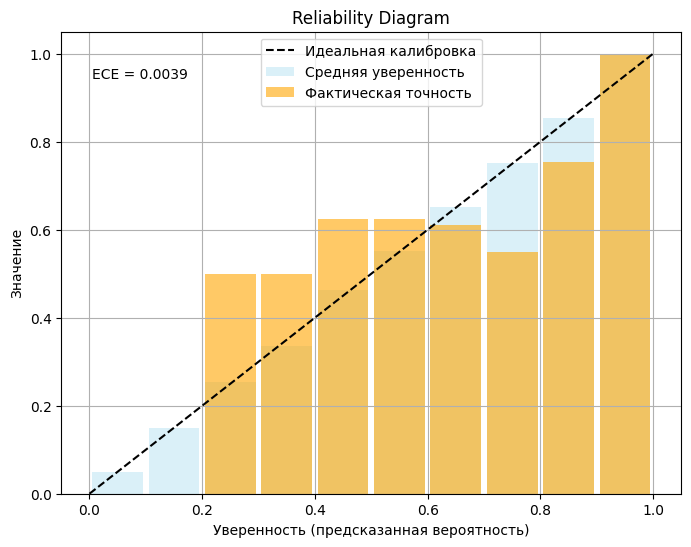

ECE: 0.0039


In [ ]:
probs, labels = get_model_predictions(model, test_loader)
plot_reliability_diagram(probs, labels)
ece = calculate_ece(probs, labels)
print(f"ECE: {ece:.4f}")

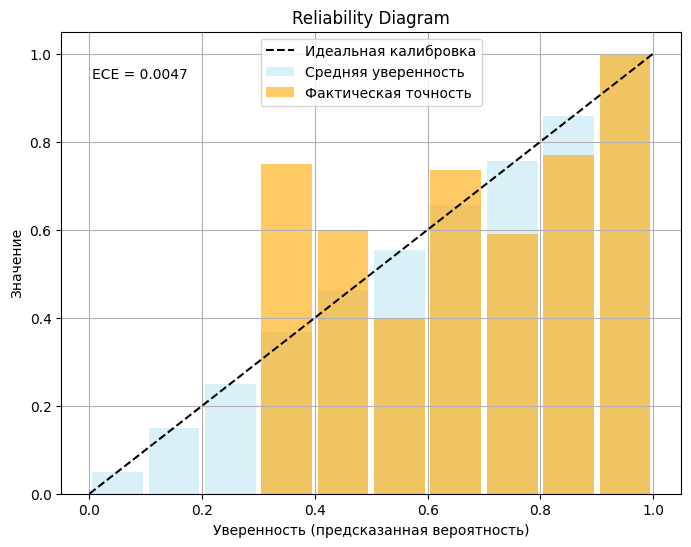

ECE: 0.0047


In [ ]:
probs2, labels2 = get_model_predictions(model2, test_loader)
plot_reliability_diagram(probs2, labels2)
ece = calculate_ece(probs2, labels2)
print(f"ECE: {ece:.4f}")

Теперь обучим `IsotonicRegression` и `Platt`.

In [ ]:
def softmax(x):
    """Вычисление softmax с устойчивостью к переполнению."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

def calibrate_predictions(method, confidences, true_labels):
    y_one_hot = label_binarize(true_labels, classes=range(10))
    calibrated_probs = np.zeros_like(confidences)

    if method == 'temperature':
        def nll_loss(T):
            scaled_probs = softmax(confidences / T)
            return -np.sum(y_one_hot * np.log(scaled_probs + 1e-15))
        res = minimize_scalar(nll_loss, bounds=(0.1, 10.0), method='bounded')
        T = res.x
        calibrated_probs = softmax(confidences / T)
    else:
        for k in range(10): # для каждого класса
            if method == 'isotonic':
                calibrator = IsotonicRegression(out_of_bounds='clip')
                calibrator.fit(confidences[:, k], y_one_hot[:, k])
                calibrated_probs[:, k] = calibrator.transform(confidences[:, k])
            elif method == 'platt':
                calibrator = LogisticRegression()
                calibrator.fit(confidences[:, k].reshape(-1, 1), y_one_hot[:, k])
                calibrated_probs[:, k] = calibrator.predict_proba(confidences[:, k].reshape(-1, 1))[:, 1]
            elif method == 'beta':
                calibrator = BetaCalibration()
                calibrator.fit(confidences[:, k].reshape(-1, 1), y_one_hot[:, k])
                calibrated_probs[:, k] = calibrator.predict(confidences[:, k])
        calibrated_probs /= calibrated_probs.sum(axis=1, keepdims=True)
    return calibrated_probs

Откалибруем вероятности для двух моделей, сначала для ResNet

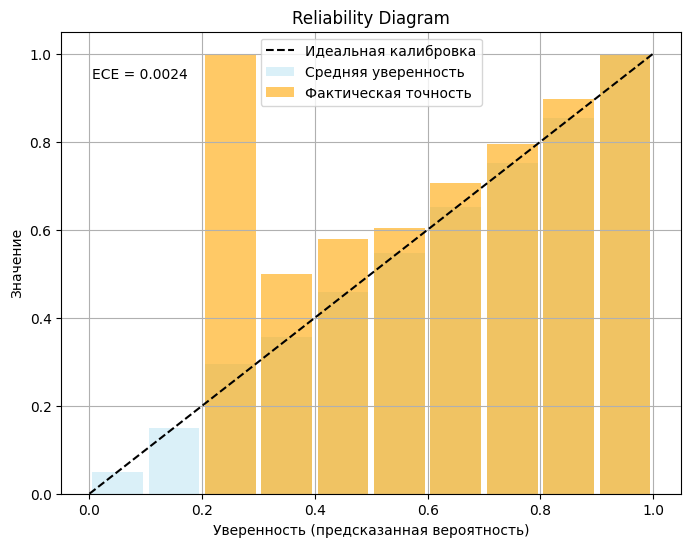

ECE: 0.0024


In [ ]:
probs_isotonic = calibrate_predictions('isotonic', probs, labels)
plot_reliability_diagram(probs_isotonic, labels)
ece = calculate_ece(probs_isotonic, labels)
print(f"ECE: {ece:.4f}")

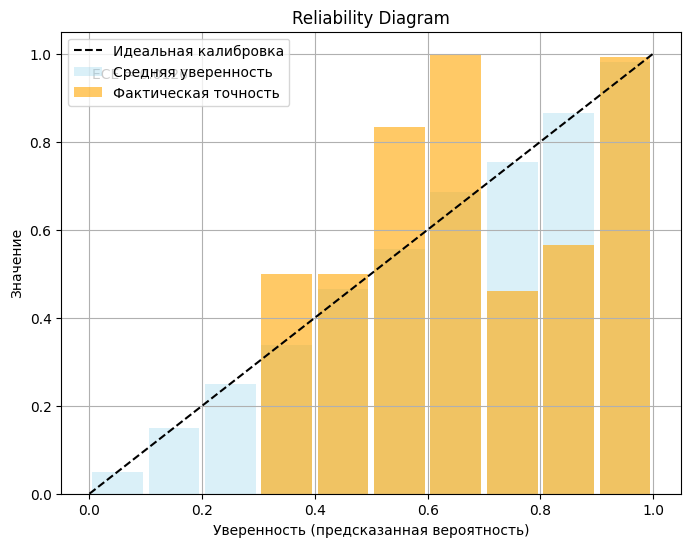

ECE: 0.0126


In [ ]:
probs_platt = calibrate_predictions('platt', probs, labels)
plot_reliability_diagram(probs_platt, labels)
ece = calculate_ece(probs_platt, labels)
print(f"ECE: {ece:.4f}")

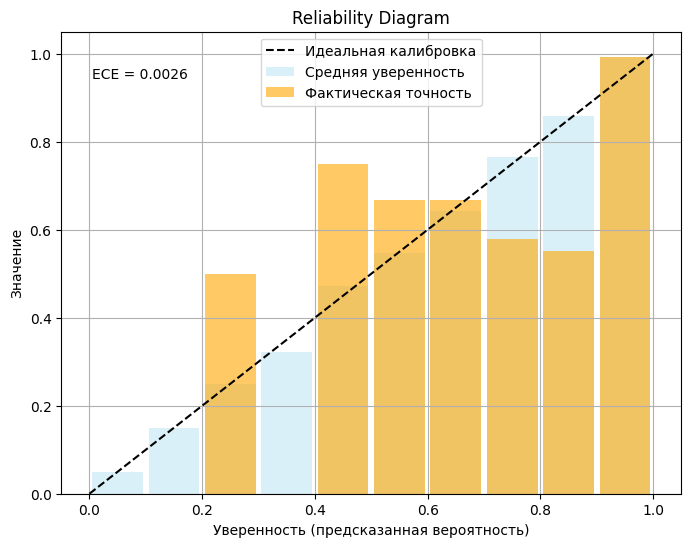

ECE: 0.0026


In [ ]:
probs_temperature = calibrate_predictions('temperature', probs, labels)
plot_reliability_diagram(probs_temperature, labels)
ece = calculate_ece(probs_temperature, labels)
print(f"ECE: {ece:.4f}")

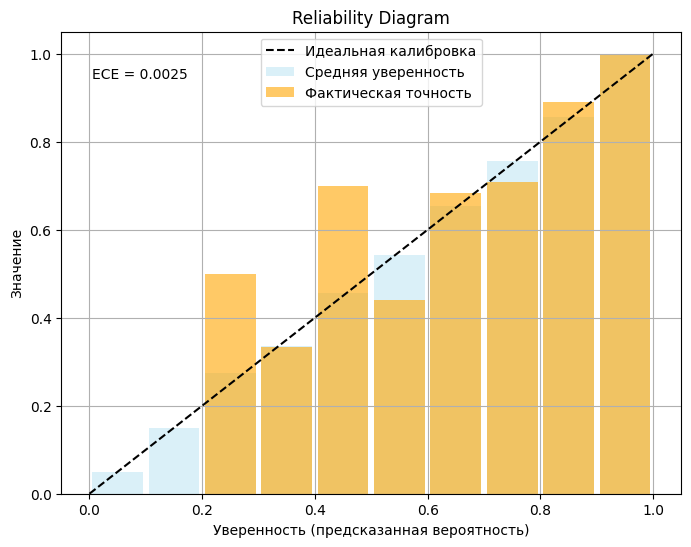

ECE: 0.0025


In [ ]:
probs_beta = calibrate_predictions('beta', probs, labels)
plot_reliability_diagram(probs_beta, labels)
ece = calculate_ece(probs_beta, labels)
print(f"ECE: {ece:.4f}")

Теперь протестим на LeNet

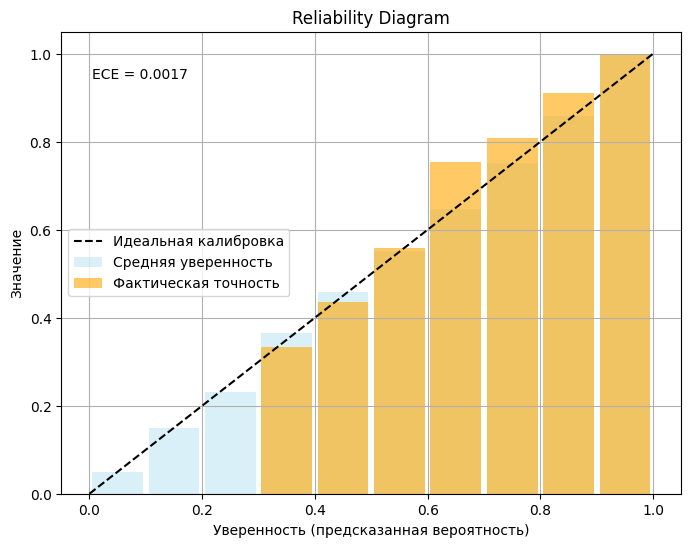

ECE: 0.0017


In [ ]:
probs2_isotonic = calibrate_predictions('isotonic', probs2, labels2)
plot_reliability_diagram(probs2_isotonic, labels2)
ece = calculate_ece(probs2_isotonic, labels2)
print(f"ECE: {ece:.4f}")

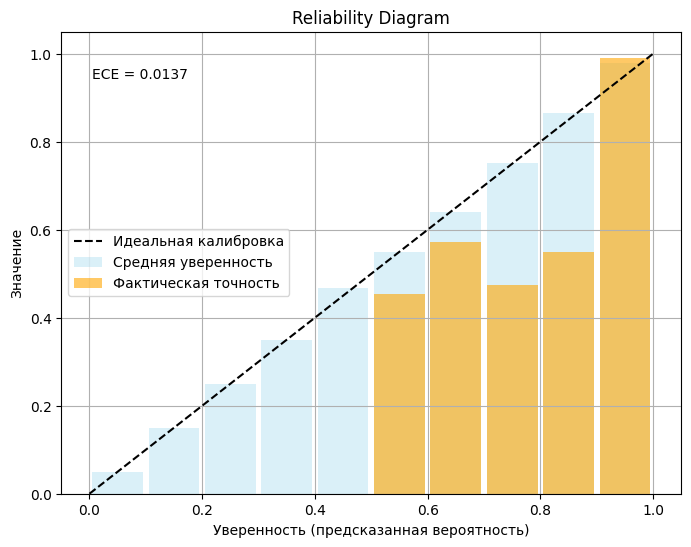

ECE: 0.0137


In [ ]:
probs2_platt = calibrate_predictions('platt', probs2, labels2)
plot_reliability_diagram(probs2_platt, labels2)
ece = calculate_ece(probs2_platt, labels2)
print(f"ECE: {ece:.4f}")

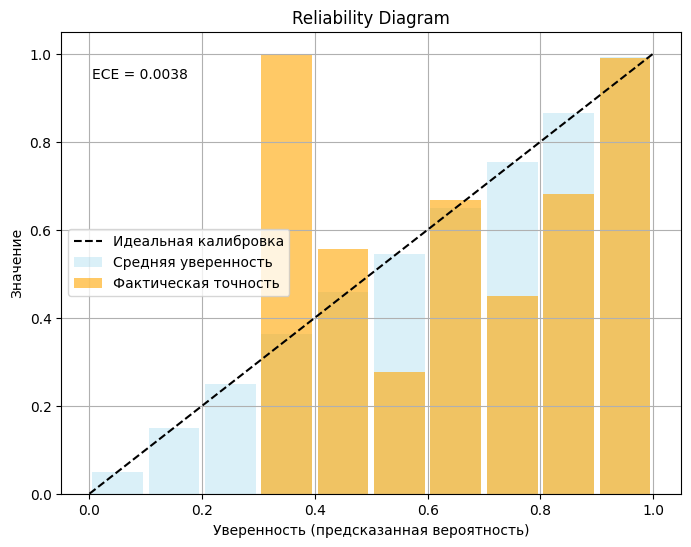

ECE: 0.0038


In [ ]:
probs2_temperature = calibrate_predictions('temperature', probs2, labels2)
plot_reliability_diagram(probs2_temperature, labels2)
ece = calculate_ece(probs2_temperature, labels2)
print(f"ECE: {ece:.4f}")

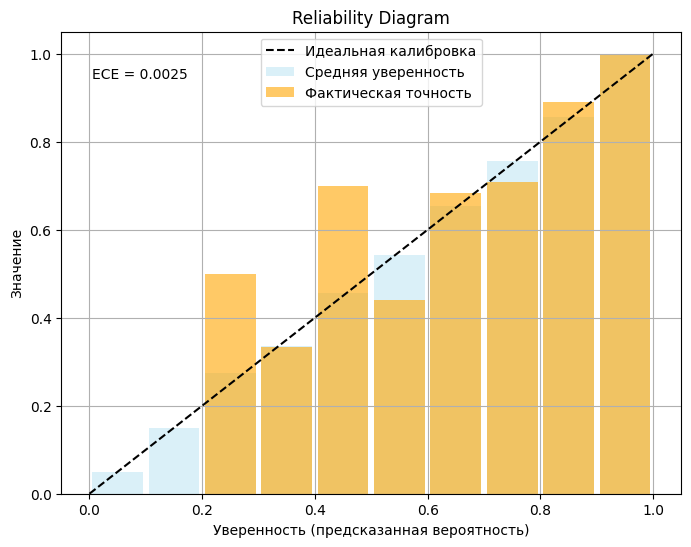

ECE: 0.0017


In [ ]:
probs2_beta = calibrate_predictions('beta', probs2, labels2)
plot_reliability_diagram(probs_beta, labels2)
ece = calculate_ece(probs2_beta, labels2)
print(f"ECE: {ece:.4f}")